In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
device = torch.device(torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))
print(f"torch.backends.mps.is_available(): {torch.backends.mps.is_available()}")

torch.backends.mps.is_available(): True


In [3]:
# Set hyperparameters
image_size = 784
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 10

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(), 
    download=True
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

In [5]:
# Create an output directory to store the reconstructed images
output_dir = 'results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

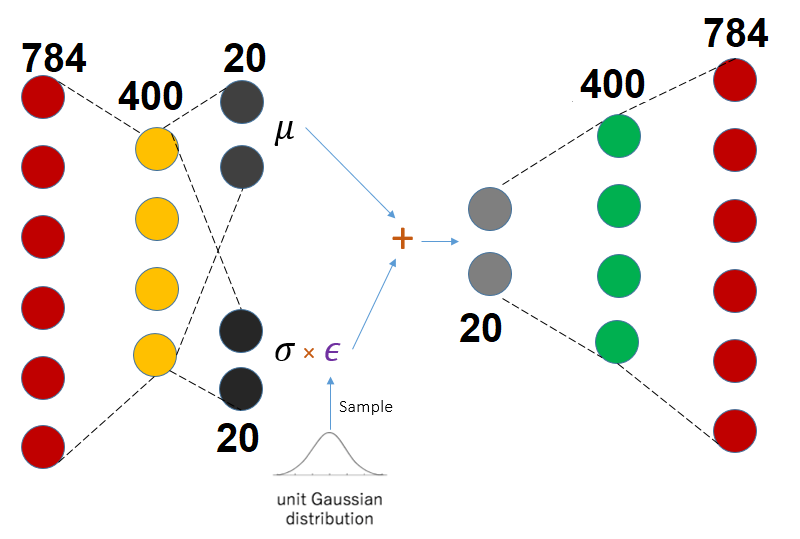

In [6]:
# Create the VAE Model class
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(image_size, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)  # Mean
        log_var = self.fc2_logvar(h)  # Std = e^(log_var/2)

        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)  #randn since we want a normal distribution

        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        
        return out

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, image_size))
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)

        return reconstructed, mu, log_var

In [7]:
# Create a model 
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Define the loss

### Loss = -E[log P(X|z)] + D<sub>KL</sub>[N($\mu$(X), $\Sigma$(X)) || N(0,1)]
### D<sub>KL</sub>[N($\mu$(X), $\Sigma$(X)) || N(0,1)] = 1/2 $\Sigma$<sub>k</sub>(exp($\Sigma$(X)) + $\mu$<sup>2</sup>(X) - 1 - $\Sigma$(X))

In [8]:
# Loss function
def loss_function(reconstructed_img, original_img, mu, logvar):
    bce = F.binary_cross_entropy(reconstructed_img, original_img.view(-1, image_size), reduction='sum')
    kld = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)
    return bce + kld

In [9]:
# Training the model
def train(epoch):
    model.train()
    train_loss =  0

    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        reconstructed, mu, logvar = model(images)
        loss = loss_function(reconstructed, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if i % 100 == 0:
            print("Train Epoch {}, [Batch {}/{}]\t Loss: {:.3f}".format(epoch, i, len(train_loader), loss.item() / len(images)))

    print("-----> Epoch {}, Avg Loss: {:.3f}".format(epoch, train_loss/len(train_loader.dataset)))

In [10]:
# Testing the model
def test(epoch):
    model.eval()
    test_loss =  0
    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            reconstructed, mu, logvar = model(images)
            loss = loss_function(reconstructed, images, mu, logvar)
            test_loss += loss.item()

            if batch_idx == 0:
                comparison = torch.cat([images[:5], reconstructed.view(batch_size, 1, 28, 28)[:5]])
                save_image(comparison.cpu(), f'results/reconstruction_{epoch}.png', nrow=5)
            

        print("-----> Avg Test Loss: {:.3f}".format(test_loss/len(test_loader.dataset)))

In [11]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        # Now we will ignore the encoder, sample z from the gaussian distribution and feed it to the decoder to generate samples
        sample = torch.rand(64, 20).to(device)
        generated = model.decode(sample).cpu()
        save_image(generated.view(64, 1, 28, 28), f'results/sample_{epoch}.png')

Train Epoch 1, [Batch 0/469]	 Loss: 545.635
Train Epoch 1, [Batch 100/469]	 Loss: 185.311
Train Epoch 1, [Batch 200/469]	 Loss: 156.736
Train Epoch 1, [Batch 300/469]	 Loss: 135.983
Train Epoch 1, [Batch 400/469]	 Loss: 134.716
-----> Epoch 1, Avg Loss: 164.318
-----> Avg Test Loss: 127.318
Train Epoch 2, [Batch 0/469]	 Loss: 129.441
Train Epoch 2, [Batch 100/469]	 Loss: 127.663
Train Epoch 2, [Batch 200/469]	 Loss: 119.583
Train Epoch 2, [Batch 300/469]	 Loss: 121.500
Train Epoch 2, [Batch 400/469]	 Loss: 112.575
-----> Epoch 2, Avg Loss: 121.521
-----> Avg Test Loss: 115.731
Train Epoch 3, [Batch 0/469]	 Loss: 113.146
Train Epoch 3, [Batch 100/469]	 Loss: 118.645
Train Epoch 3, [Batch 200/469]	 Loss: 118.425
Train Epoch 3, [Batch 300/469]	 Loss: 115.175
Train Epoch 3, [Batch 400/469]	 Loss: 114.439
-----> Epoch 3, Avg Loss: 114.613
-----> Avg Test Loss: 111.820
Train Epoch 4, [Batch 0/469]	 Loss: 111.114
Train Epoch 4, [Batch 100/469]	 Loss: 112.950
Train Epoch 4, [Batch 200/469]	 Lo